In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


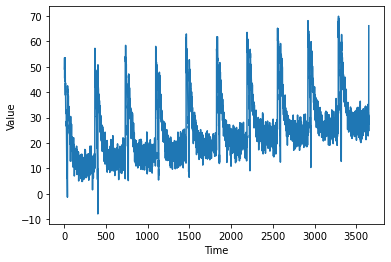

In [35]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [36]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [37]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
history = model.fit(dataset,epochs=100,verbose=2)

Epoch 1/100
94/94 - 1s - loss: 293.1937
Epoch 2/100
94/94 - 1s - loss: 44.4083
Epoch 3/100
94/94 - 1s - loss: 42.0967
Epoch 4/100
94/94 - 1s - loss: 40.5313
Epoch 5/100
94/94 - 1s - loss: 39.1361
Epoch 6/100
94/94 - 1s - loss: 37.9675
Epoch 7/100
94/94 - 1s - loss: 37.0270
Epoch 8/100
94/94 - 1s - loss: 36.3990
Epoch 9/100
94/94 - 1s - loss: 35.4806
Epoch 10/100
94/94 - 1s - loss: 35.0498
Epoch 11/100
94/94 - 1s - loss: 34.3466
Epoch 12/100
94/94 - 1s - loss: 33.9010
Epoch 13/100
94/94 - 1s - loss: 33.3754
Epoch 14/100
94/94 - 1s - loss: 32.9779
Epoch 15/100
94/94 - 1s - loss: 32.6125
Epoch 16/100
94/94 - 1s - loss: 32.2451
Epoch 17/100
94/94 - 1s - loss: 31.8898
Epoch 18/100
94/94 - 1s - loss: 31.5937
Epoch 19/100
94/94 - 1s - loss: 31.3316
Epoch 20/100
94/94 - 1s - loss: 31.0132
Epoch 21/100
94/94 - 1s - loss: 30.8081
Epoch 22/100
94/94 - 1s - loss: 30.5717
Epoch 23/100
94/94 - 1s - loss: 30.3356
Epoch 24/100
94/94 - 1s - loss: 30.0407
Epoch 25/100
94/94 - 1s - loss: 29.9273
Epoch 26

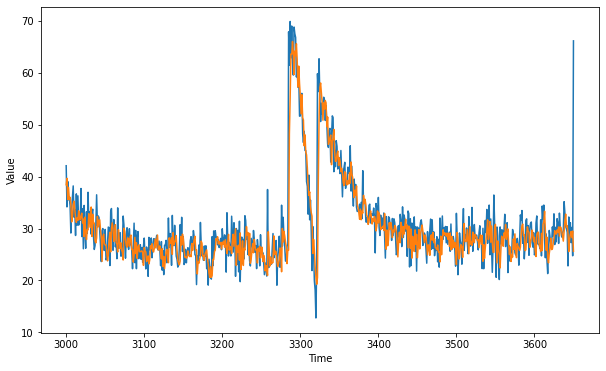

In [38]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [39]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# EXPECTED OUTPUT
# A Value less than 3
# Not less 3 but not bad, still a good model

3.1766343

[34.34658432006836, 33.900997161865234, 33.3753662109375, 32.9779167175293, 32.61247634887695, 32.24509048461914, 31.88975715637207, 31.593698501586914, 31.331571578979492, 31.01321029663086, 30.80811882019043, 30.571651458740234, 30.335586547851562, 30.040672302246094, 29.927257537841797, 29.72132110595703, 29.510793685913086, 29.32552146911621, 29.197317123413086, 29.048465728759766, 28.901134490966797, 28.7354679107666, 28.560266494750977, 28.46308135986328, 28.284839630126953, 28.243364334106445, 28.086666107177734, 27.941425323486328, 27.87278938293457, 27.72224235534668, 27.635173797607422, 27.479612350463867, 27.45469856262207, 27.368207931518555, 27.250606536865234, 27.135772705078125, 27.067646026611328, 26.986061096191406, 26.898204803466797, 26.866220474243164, 26.75664520263672, 26.77371597290039, 26.613584518432617, 26.60715675354004, 26.5090389251709, 26.381834030151367, 26.353166580200195, 26.305072784423828, 26.23987579345703, 26.24675178527832, 26.19117546081543, 26.11

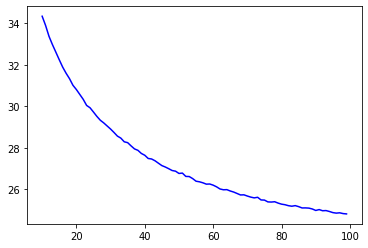

In [40]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()